In [826]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

In [827]:
df_train = pd.read_csv('train.csv', index_col='PassengerId') # датасет для обучения
df_test = pd.read_csv('test.csv', index_col='PassengerId') # датасет для предсказания
sample_submission = pd.read_csv('gender_submission.csv') # самбмишн
df_train.info()
df_train.describe(include = 'object')
df_train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [828]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [829]:
df_test.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [830]:
sample_submission.head(2)

,PassengerId,Survived
0,892,0
1,893,1


In [831]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
#df_train['sample'] = 1 # помечаем где у нас трейн
#df_test['sample'] = 0 # помечаем где у нас тест
#df_test['Survived'] = 0 # в тесте у нас нет значения Survived, мы его должны предсказать, по этому пока просто заполняем нулями

#df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [832]:
df_train.nunique(dropna=False)

Survived      2
Pclass        3
Name        891
Sex           2
Age          89
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       148
Embarked      4
dtype: int64

Исследование целевого признака survived

In [833]:
types = df_train.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

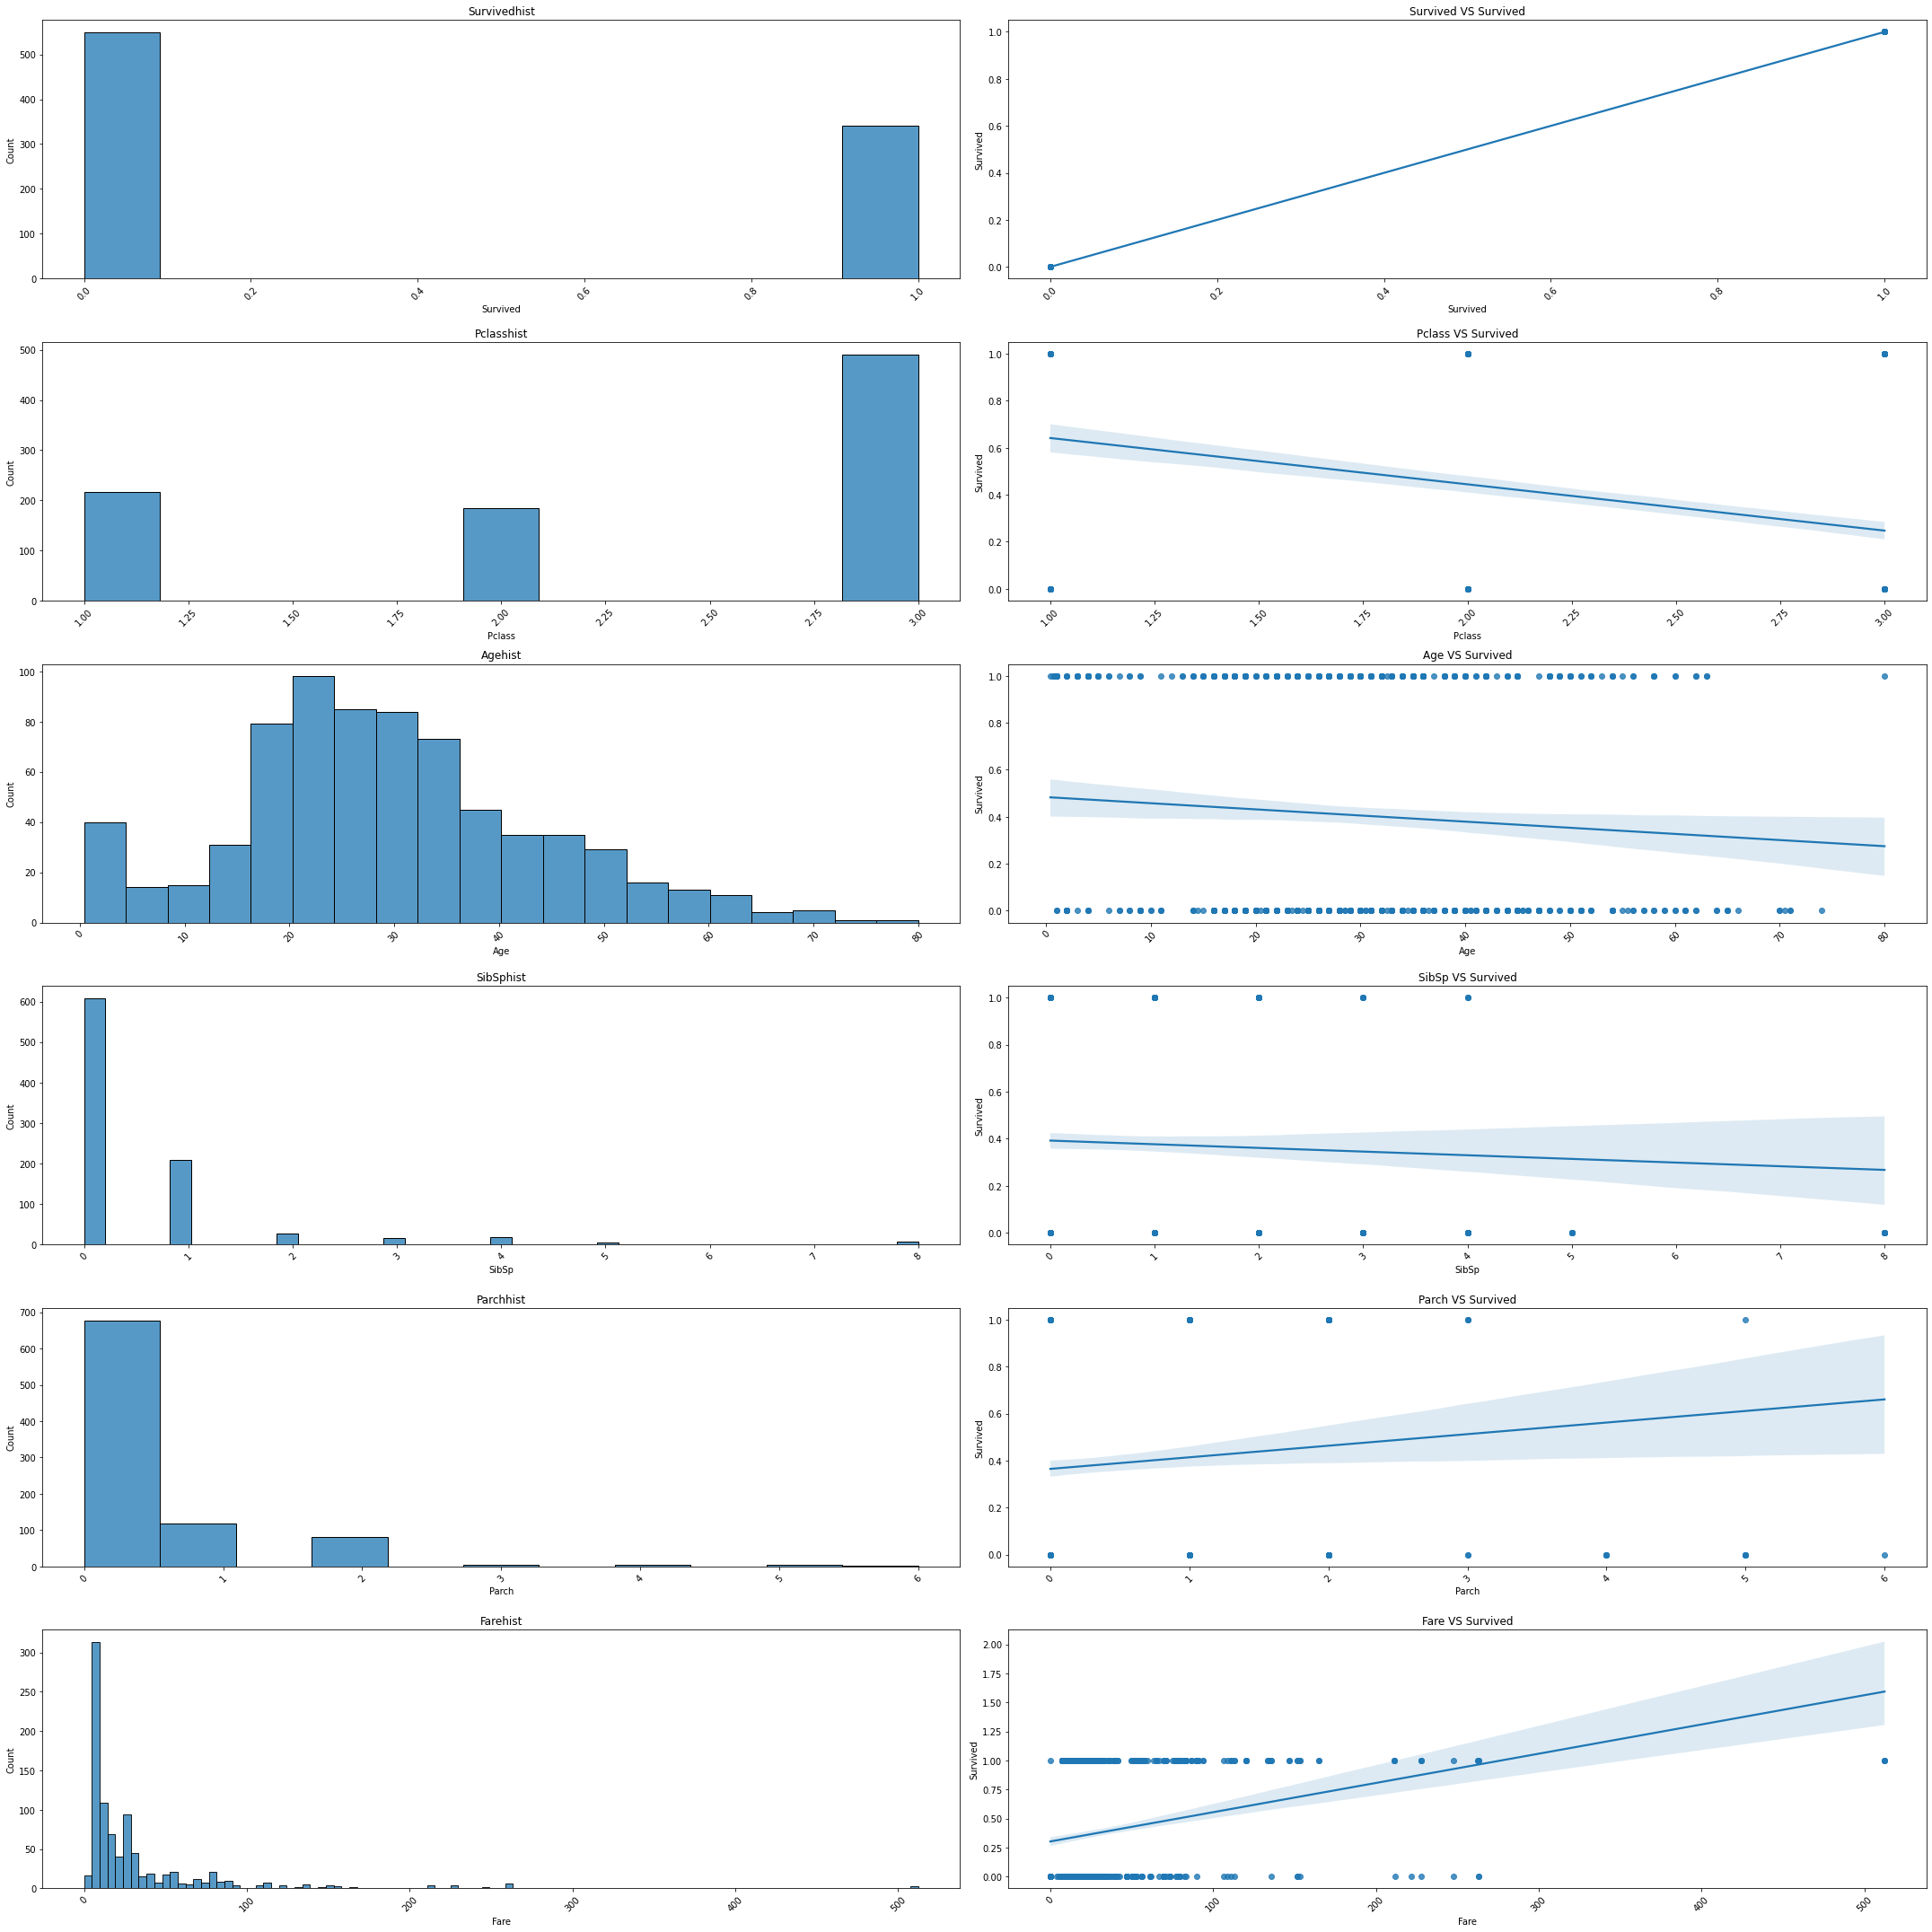

In [834]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots (n, 2, figsize = (30, 30))
for i, feature in enumerate (num_features):
  histplot = sns.histplot(data = df_train, x = feature, ax=axes[i][0])
  histplot.set_title('{}hist'.format(feature))
  histplot.xaxis.set_tick_params(rotation=45)
  regplot = sns.regplot(data = df_train, x = feature, y = 'Survived', ax = axes[i][1])
  regplot.set_title('{} VS Survived'.format(feature))
  regplot.xaxis.set_tick_params(rotation=45)
  plt.tight_layout()
                        

**Строим тепловую карту для корреляционной матрицы**

<AxesSubplot:>

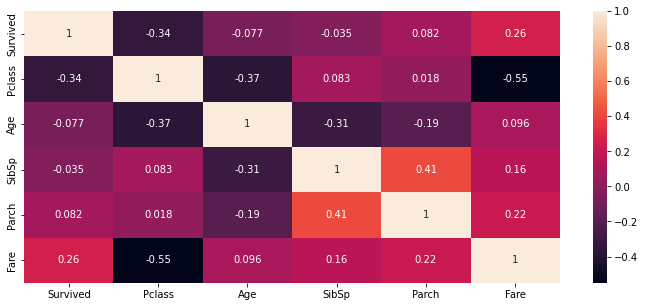

In [835]:
fig = plt.figure(figsize = (12,5))
sns.heatmap(df_train.corr(), annot=True)

**Работа с признаком Age**

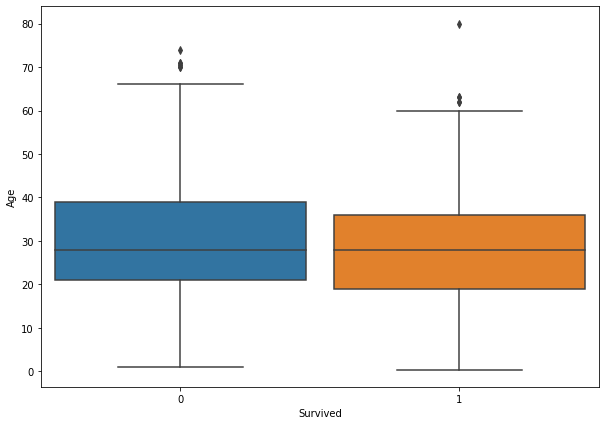

In [836]:
#Работа с признаком Age - выясняем есть ли выбросы и пропуски
fig = plt.figure(figsize = (10, 7))
boxplot = sns.boxplot(data =df_train, y = 'Age', x = 'Survived', width = 0.9)

fig = px.histogram(
    data_frame=df_train,
    x='Age',
    title='Распределение возраста пассажиров',
    histnorm='percent',
    width=1000,
    marginal='box'
    )
fig.show()

In [837]:
#Заполняем модальным значением признак возраста в датасете трейн
values = {'Age': df_train['Age'].median()}
df_train = df_train.fillna(values)
df_train.isnull().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.000000
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

In [838]:
#Заменяем пропуски в тестовом датасете
values_test = {'Age': df_test['Age'].median()}
df_test = df_test.fillna(values_test)
df_test.isnull().mean()

Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.000000
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.002392
Cabin       0.782297
Embarked    0.000000
dtype: float64

In [839]:
#Кодируем признак Age по группам - возрастам
#def func(arg): 
    #if arg <18:
        #return '1'
    #elif 18<arg <50:
        #return '2'
    #elif arg >50:
        #return '3'
  
    
        
#df_train['Age_group'] = df_train['Age'].apply(func) 
#df_train = df_train.drop('Age', axis = 1)
#df_test['Age_group'] = df_test['Age'].apply(func) 
#df_test = df_test.drop('Age', axis = 1)
#df_train.isnull().sum()
#values_1 = {'Age_group': df['Age_group'].mode()[0]}
#df = df.fillna(values_1)
#df

In [840]:
#Удаляем неинформативные столбцы = каюта, имя, ticket  = так как они не несут никакой смысловой нагрузки
df_train = df_train.drop(['Cabin', 'Name', 'Ticket'], axis =1)
df_test = df_test.drop(['Cabin', 'Name', 'Ticket'], axis =1)
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,S
888,1,1,female,19.0,0,0,30.0000,S
889,0,3,female,28.0,1,2,23.4500,S


**Работа с признаком Fare**

In [841]:
#Заполняем пропуск в Fare медианным значением
values_fare_train = {'Fare': df_train['Fare'].median()}
df_train = df_train.fillna(values_fare_train)
values_fare_test = {'Fare': df_test['Fare'].median()}
df_test = df_test.fillna(values_fare_test)
df_train.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [842]:
#Ищем выборсы в признаке Fare
#(работа с выбросами ручным способом)
#найдем строки, в которых стоимость билета была нулевой
display(df_train[df_train['Fare']==0])
display(df_test[df_test['Fare']==0])

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
180,0,3,male,36.0,0,0,0.0,S
264,0,1,male,40.0,0,0,0.0,S
272,1,3,male,25.0,0,0,0.0,S
278,0,2,male,28.0,0,0,0.0,S
303,0,3,male,19.0,0,0,0.0,S
414,0,2,male,28.0,0,0,0.0,S
467,0,2,male,28.0,0,0,0.0,S
482,0,2,male,28.0,0,0,0.0,S
598,0,3,male,49.0,0,0,0.0,S


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1158,1,male,27.0,0,0,0.0,S
1264,1,male,49.0,0,0,0.0,S


Число выбросов:116
Результирующее число:891


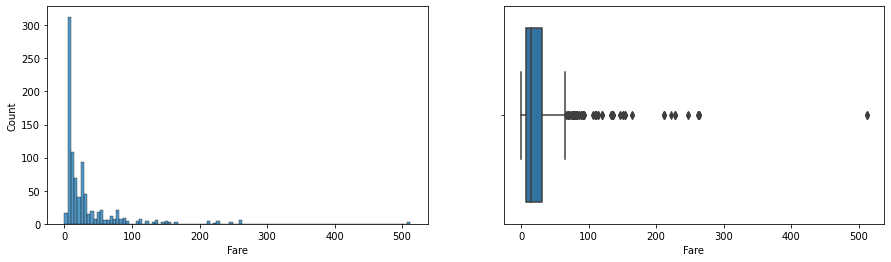

In [843]:
#Проверим выбросы в Fare по методу межквартильного размаха
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))
histplot = sns.histplot(data = df_train, x = 'Fare', ax = axes[0]);
boxplot= sns.boxplot(data = df_train, x = 'Fare', ax = axes[1])
def outliers_iqr(data, feature):
  x = data[feature]
  quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
  iqr = quartile_3 - quartile_1
  lower_bound = quartile_1 - (iqr * 1.5)
  upper_bound = quartile_3 + (iqr * 1.5)
  outliers = data [(x<lower_bound)|(x>upper_bound)]
  cleaned = data [(x>lower_bound)|(x<upper_bound)]
  return outliers, cleaned
outliers, cleaned = outliers_iqr(df_train, 'Fare')
print(f'Число выбросов:{outliers.shape[0]}')
print(f'Результирующее число:{cleaned.shape[0]}')

In [844]:
#найдем и удалим выброс с максимально дорогой стоимостью билета 
#df_train[df_train['Fare']==512.3292]
#df_train = df_train.drop(labels = [259,680,738], axis = 0)
#df_test[df_test['Fare']==512.3292]
#df_test = df_test.drop(labels = 1235, axis = 0)

**Работа с признаком Embarked**

In [845]:
#Заполняем пропуски модальными значениями
values_train_embarked = {'Embarked': df_train['Embarked'].mode()[0]}
df_train = df_train.fillna(values_train_embarked)
values_test_embarked = {'Embarked': df_test['Embarked'].mode()[0]}
df_test = df_test.fillna(values_test_embarked)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 26.1+ KB


**Создаем новый признак "Family_size"**

In [846]:

df_train['Family_size'] = df_train['Parch'] + df_train['SibSp']
df_train = df_train.drop(['Parch', 'SibSp'], axis =1) #а признаки Parch и SibSp удаляем
df_test['Family_size'] = df_test['Parch'] + df_test['SibSp']
df_test = df_test.drop(['Parch', 'SibSp'], axis =1)
df_train

,Survived,Pclass,Sex,Age,Fare,Embarked,Family_size
PassengerId,,,,,,,
1,0,3,male,22.0,7.2500,S,1
2,1,1,female,38.0,71.2833,C,1
3,1,3,female,26.0,7.9250,S,0
4,1,1,female,35.0,53.1000,S,1
5,0,3,male,35.0,8.0500,S,0
...,...,...,...,...,...,...,...
887,0,2,male,27.0,13.0000,S,0
888,1,1,female,19.0,30.0000,S,0
889,0,3,female,28.0,23.4500,S,3


**Кодирование признаков**

In [847]:
y_train = df_train['Survived']
train_sep = df_train.drop(columns=['Survived'])

In [848]:
def encode_categorial(df_train, df_test):
    test_start_ind=df_train.index[-1]
    concated_df =pd.concat([df_train, df_test], sort=False)
    encoded_df = pd.get_dummies(concated_df, drop_first=True)
    df_train_encoded, df_test_encoded = encoded_df.iloc[:test_start_ind, :], encoded_df.iloc[test_start_ind:, :] 
    return df_train_encoded, df_test_encoded

In [849]:
X_train, X_test = encode_categorial(train_sep, df_test)
X_train

,Pclass,Age,Fare,Family_size,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,
1,3,22.0,7.2500,1,1,0,1
2,1,38.0,71.2833,1,0,0,0
3,3,26.0,7.9250,0,0,0,1
4,1,35.0,53.1000,1,0,0,1
5,3,35.0,8.0500,0,1,0,1
...,...,...,...,...,...,...,...
887,2,27.0,13.0000,0,1,0,1
888,1,19.0,30.0000,0,0,0,1
889,3,28.0,23.4500,3,0,0,1


**Обучаем методом случайного дерева**

In [850]:
dt_clf = DecisionTreeClassifier()

In [851]:
%%time
dt_clf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 2.99 ms


DecisionTreeClassifier()

In [852]:
pred_dt_simple=dt_clf.predict(X_test)

*Поиск гипермараметров Gridsearch*

In [853]:
from sklearn.model_selection import GridSearchCV

In [854]:
clf = DecisionTreeClassifier()
parameters= {
    'criterion':['entropy', 'gini'],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf':range(1, 10)
}
grid_cv = GridSearchCV(clf, parameters, cv=5)

In [855]:
%%time
grid_cv.fit(X_train, y_train)

CPU times: total: 17.1 s
Wall time: 17.1 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10)})

In [857]:
best_model = grid_cv.best_estimator_
print('Лучшие параметры классификатора:', grid_cv.best_params_)

Лучшие параметры классификатора: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2}


In [858]:
grid_pred = best_model.predict(X_test)

*Поиск гиперпараметров по GridSearch Random*

In [859]:
from sklearn.model_selection import RandomizedSearchCV

In [860]:
random_grid_cv = RandomizedSearchCV(clf, parameters, cv=5)

In [862]:
%%time
random_grid_cv.fit(X_train, y_train)

CPU times: total: 156 ms
Wall time: 150 ms


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': range(1, 10),
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 10)})

In [863]:
best_model_rand = random_grid_cv.best_estimator_
print('Лучшие параметры классификатора:', random_grid_cv.best_params_)

Лучшие параметры классификатора: {'min_samples_split': 5, 'min_samples_leaf': 6, 'max_depth': 8, 'criterion': 'gini'}


In [864]:
rand_grid_pred = best_model_rand.predict(X_test)

**Создаем функцию для оформления сабмишна**

In [865]:
def make_prediction_file(prediction, test_data, name):
    result = pd.DataFrame({'PassengerId':test_data.reset_index()['PassengerId'], 'Survived':prediction})
    result.to_csv(name, index=False)

***Создаем сабмишны для деревьев***

In [868]:
make_prediction_file(pred_dt_simple, df_test, 'titanic_dt_simple')
make_prediction_file(grid_pred, df_test, 'titanic_grid_pred')
make_prediction_file(rand_grid_pred, df_test, 'titanic_rand_grid_pred')